# Fine-Tuning a Vision Language Model with the Hugging Face Ecosystem (TRL)

# Load dataset

### Chart dataset

In [1]:
system_message = """You are a Vision Language Model specialized in interpreting visual data from chart images.
Your task is to analyze the provided chart image and respond to queries with concise answers, usually a single word, number, or short phrase.
The charts include a variety of types (e.g., line charts, bar charts) and contain colors, labels, and text.
Focus on delivering accurate, succinct answers based on the visual information. Avoid additional explanation unless absolutely necessary."""

In [2]:
def format_data(sample):
    return [
        {
            "role": "system",
            "content": [{"type": "text", "text": system_message}],
        },
        {
            "role": "user",
            "content": [
                {
                    "type": "image",
                    "image": sample["image"],
                },
                {
                    "type": "text",
                    "text": sample["query"],
                },
            ],
        },
        {
            "role": "assistant",
            "content": [{"type": "text", "text": sample["label"][0]}],
        },
    ]

In [3]:
from datasets import load_dataset

dataset_id = "HuggingFaceM4/ChartQA"
train_dataset, eval_dataset, test_dataset = load_dataset(dataset_id, split=["train", "val", "test"])

In [4]:
train_dataset = [format_data(sample) for sample in train_dataset]
eval_dataset = [format_data(sample) for sample in eval_dataset]
test_dataset = [format_data(sample) for sample in test_dataset]

### Amazon reviews dataset

In [1]:
from datasets import load_dataset
from PIL import Image

# System message for the assistant
system_message = "You are an expert product description writer for Amazon."

# User prompt that combines the user query and the schema
user_prompt = """Create a Short Product description based on the provided <PRODUCT> and <CATEGORY> and image.
Only return description. The description should be SEO optimized and for a better mobile search experience.

<PRODUCT>
{product}
</PRODUCT>

<CATEGORY>
{category}
</CATEGORY>
"""

# Convert dataset to OAI messages
def format_data(sample):
    return {
        "messages": [
            {
                "role": "system",
                "content": [{"type": "text", "text": system_message}],
            },
            {
                "role": "user",
                "content": [
                    {
                        "type": "text",
                        "text": user_prompt.format(
                            product=sample["Product Name"],
                            category=sample["Category"],
                        ),
                    },
                    {
                        "type": "image",
                        "image": sample["image"],
                    },
                ],
            },
            {
                "role": "assistant",
                "content": [{"type": "text", "text": sample["description"]}],
            },
        ],
    }

# Load dataset from the hub
dataset = load_dataset("philschmid/amazon-product-descriptions-vlm", split="train")

# Convert dataset to OAI messages
# need to use list comprehension to keep Pil.Image type, .mape convert image to bytes
train_dataset = [format_data(sample) for sample in dataset]

{'messages': [{'role': 'system',
   'content': [{'type': 'text',
     'text': 'You are an expert product description writer for Amazon.'}]},
  {'role': 'user',
   'content': [{'type': 'text',
     'text': 'Create a Short Product description based on the provided <PRODUCT> and <CATEGORY> and image.\nOnly return description. The description should be SEO optimized and for a better mobile search experience.\n\n<PRODUCT>\nQualatex Foil Balloon 13955 Little Man Bow-tie, 18", Multicolor\n</PRODUCT>\n\n<CATEGORY>\nToys & Games | Party Supplies | Balloons\n</CATEGORY>\n'},
    {'type': 'image',
     'image': <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=414x500>}]},
  {'role': 'assistant',
   'content': [{'type': 'text',
     'text': 'Make your party extra special with this Qualatex Foil Balloon!  This adorable 18" Little Man Bow-tie balloon in multicolor adds a fun, festive touch to any celebration. Perfect for birthdays, baby showers, or any party needing a whimsical flair.  High-qu

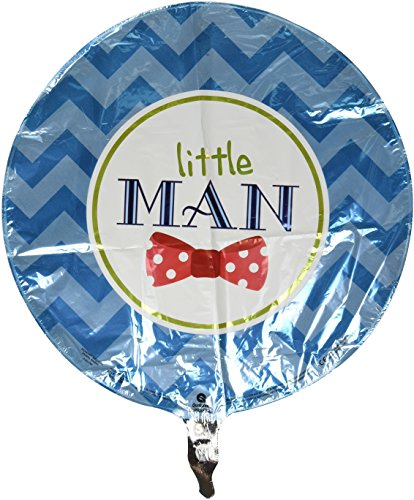

In [2]:
# train_dataset[200]
display(train_dataset[10])
display(train_dataset[10]["messages"][1]['content'][1]['image'])

### Load the model

### Qwen

In [ ]:
import torch
from transformers import Qwen2VLForConditionalGeneration, Qwen2VLProcessor

model_id = "Qwen/Qwen2-VL-7B-Instruct"

In [10]:
model = Qwen2VLForConditionalGeneration.from_pretrained(
    model_id,
    device_map="auto",
    torch_dtype=torch.bfloat16,
)

processor = Qwen2VLProcessor.from_pretrained(model_id)

Loading checkpoint shards:   0%|          | 0/5 [00:00<?, ?it/s]

Using a slow image processor as `use_fast` is unset and a slow processor was saved with this model. `use_fast=True` will be the default behavior in v4.52, even if the model was saved with a slow processor. This will result in minor differences in outputs. You'll still be able to use a slow processor with `use_fast=False`.


### Evaluate the model before fine-tuning

### 1. use without system message

In [3]:
from qwen_vl_utils import process_vision_info


def generate_text_from_sample(model, processor, sample, max_new_tokens=1024, device="cuda"):
    # Prepare the text input by applying the chat template
    text_input = processor.apply_chat_template(
        sample, tokenize=False, add_generation_prompt=True  # Use the sample without the system message
    )

    # Process the visual input from the sample
    image_inputs, _ = process_vision_info(sample)

    # Prepare the inputs for the model
    model_inputs = processor(
        text=[text_input],
        images=image_inputs,
        return_tensors="pt",
    ).to(
        device
    )  # Move inputs to the specified device

    # Generate text with the model
    generated_ids = model.generate(**model_inputs, max_new_tokens=max_new_tokens)

    # Trim the generated ids to remove the input ids
    trimmed_generated_ids = [out_ids[len(in_ids) :] for in_ids, out_ids in zip(model_inputs.input_ids, generated_ids)]

    # Decode the output text
    output_text = processor.batch_decode(
        trimmed_generated_ids, skip_special_tokens=True, clean_up_tokenization_spaces=False
    )

    return output_text[0]  # Return the first decoded output text

In [16]:
# Example of how to call the method with sample:
output = generate_text_from_sample(model, processor, train_dataset[0]['messages'])
output

'Discover the Kurio Glow Smartwatch, the perfect blend of fun and education for kids! This smartwatch features Bluetooth connectivity, built-in apps and games, and a camera, all in a vibrant blue design. Perfect for learning and play, the Kurio Glow Smartwatch is the ultimate toy for your little one. #kidssmartwatch #kidselectronics #educationaltoys #kurioglow'

# Fine-Tune the Model using TRL

##  1. Load the Quantized Model for Training

In [17]:
from transformers import BitsAndBytesConfig
import torch
from transformers import Qwen2VLForConditionalGeneration, Qwen2VLProcessor

model_id = "Qwen/Qwen2-VL-7B-Instruct"

# BitsAndBytesConfig int-4 config
bnb_config = BitsAndBytesConfig(
    load_in_4bit=True, bnb_4bit_use_double_quant=True, bnb_4bit_quant_type="nf4", bnb_4bit_compute_dtype=torch.bfloat16
)

# Load model and tokenizer
model = Qwen2VLForConditionalGeneration.from_pretrained(
    model_id, device_map="auto", torch_dtype=torch.bfloat16, quantization_config=bnb_config
)
processor = Qwen2VLProcessor.from_pretrained(model_id)

Loading checkpoint shards:   0%|          | 0/5 [00:00<?, ?it/s]

In [18]:
from peft import LoraConfig, get_peft_model

# Configure LoRA
peft_config = LoraConfig(
    lora_alpha=16,
    lora_dropout=0.05,
    r=8,
    bias="none",
    target_modules=["q_proj", "v_proj"],
    task_type="CAUSAL_LM",
)

# Apply PEFT model adaptation
peft_model = get_peft_model(model, peft_config)

# Print trainable parameters
peft_model.print_trainable_parameters()

trainable params: 2,523,136 || all params: 8,293,898,752 || trainable%: 0.0304


In [20]:
from trl import SFTConfig

# Configure training arguments
training_args = SFTConfig(
    output_dir="qwen2-7b-instruct-trl-sft-amazon-description",  # Directory to save the model
    num_train_epochs=10,  # Number of training epochs
    per_device_train_batch_size=4,  # Batch size for training
    per_device_eval_batch_size=4,  # Batch size for evaluation
    gradient_accumulation_steps=8,  # Steps to accumulate gradients
    gradient_checkpointing=True,  # Enable gradient checkpointing for memory efficiency
    # Optimizer and scheduler settings
    optim="adamw_torch_fused",  # Optimizer type
    learning_rate=2e-4,  # Learning rate for training
    lr_scheduler_type="constant",  # Type of learning rate scheduler
    # Logging and evaluation
    logging_steps=10,  # Steps interval for logging
    # eval_steps=100,  # Steps interval for evaluation
    # eval_strategy="steps",  # Strategy for evaluation
    save_strategy="steps",  # Strategy for saving the model
    save_steps=100,  # Steps interval for saving
    # metric_for_best_model="eval_loss",  # Metric to evaluate the best model
    # greater_is_better=False,  # Whether higher metric values are better
    # load_best_model_at_end=True,  # Load the best model after training
    # Mixed precision and gradient settings
    bf16=True,  # Use bfloat16 precision
    # tf32=True,  # Use TensorFloat-32 precision
    max_grad_norm=0.3,  # Maximum norm for gradient clipping
    warmup_ratio=0.03,  # Ratio of total steps for warmup
    # Hub and reporting
    push_to_hub=True,  # Whether to push model to Hugging Face Hub
    report_to="tensorboard",  # Reporting tool for tracking metrics
    # Gradient checkpointing settings
    gradient_checkpointing_kwargs={"use_reentrant": False},  # Options for gradient checkpointing
    # Dataset configuration
    dataset_text_field="",  # Text field in dataset
    dataset_kwargs={"skip_prepare_dataset": True},  # Additional dataset options
    # max_seq_length=1024  # Maximum sequence length for input
)

training_args.remove_unused_columns = False  # Keep unused columns in dataset

In [21]:
# Create a data collator to encode text and image pairs
from qwen_vl_utils import process_vision_info

def collate_fn(examples):
    # Get the texts and images, and apply the chat template
    texts = [
        processor.apply_chat_template(example['messages'], tokenize=False) for example in examples
    ]  # Prepare texts for processing
    image_inputs = [process_vision_info(example['messages'])[0] for example in examples]  # Process the images to extract inputs

    # Tokenize the texts and process the images
    batch = processor(
        text=texts, images=image_inputs, return_tensors="pt", padding=True
    )  # Encode texts and images into tensors

    # The labels are the input_ids, and we mask the padding tokens in the loss computation
    labels = batch["input_ids"].clone()  # Clone input IDs for labels
    labels[labels == processor.tokenizer.pad_token_id] = -100  # Mask padding tokens in labels

    # Ignore the image token index in the loss computation (model specific)
    if isinstance(processor, Qwen2VLProcessor):  # Check if the processor is Qwen2VLProcessor
        image_tokens = [151652, 151653, 151655]  # Specific image token IDs for Qwen2VLProcessor
    else:
        image_tokens = [processor.tokenizer.convert_tokens_to_ids(processor.image_token)]  # Convert image token to ID

    # Mask image token IDs in the labels
    for image_token_id in image_tokens:
        labels[labels == image_token_id] = -100  # Mask image token IDs in labels

    batch["labels"] = labels  # Add labels to the batch

    return batch  # Return the prepared batch

# Now train!!

In [23]:
from trl import SFTTrainer

trainer = SFTTrainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    # eval_dataset=eval_dataset,
    data_collator=collate_fn,
    peft_config=peft_config,
    processing_class=processor,
)

/home/ubuntu/miniforge3/envs/pt24_py311/lib/python3.11/site-packages/peft/mapping_func.py:73: UserWarning: You are trying to modify a model with PEFT for a second time. If you want to reload the model with a different config, make sure to call `.unload()` before.
  warnings.warn(
/home/ubuntu/miniforge3/envs/pt24_py311/lib/python3.11/site-packages/peft/tuners/tuners_utils.py:167: UserWarning: Already found a `peft_config` attribute in the model. This will lead to having multiple adapters in the model. Make sure to know what you are doing!
  warnings.warn(
No label_names provided for model class `PeftModelForCausalLM`. Since `PeftModel` hides base models input arguments, if label_names is not given, label_names can't be set automatically within `Trainer`. Note that empty label_names list will be used instead.


In [24]:
trainer.train()

`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...
/home/ubuntu/miniforge3/envs/pt24_py311/lib/python3.11/site-packages/torch/utils/checkpoint.py:1399: FutureWarning: `torch.cpu.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cpu', args...)` instead.
  with device_autocast_ctx, torch.cpu.amp.autocast(**cpu_autocast_kwargs), recompute_context:  # type: ignore[attr-defined]


Step,Training Loss
10,2.486900
20,1.762800
30,1.188700
40,0.989100
50,0.834100
60,0.869800
70,0.812800
80,0.790600
90,0.699700
100,0.739300


/home/ubuntu/miniforge3/envs/pt24_py311/lib/python3.11/site-packages/torch/utils/checkpoint.py:1399: FutureWarning: `torch.cpu.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cpu', args...)` instead.
  with device_autocast_ctx, torch.cpu.amp.autocast(**cpu_autocast_kwargs), recompute_context:  # type: ignore[attr-defined]
/home/ubuntu/miniforge3/envs/pt24_py311/lib/python3.11/site-packages/torch/utils/checkpoint.py:1399: FutureWarning: `torch.cpu.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cpu', args...)` instead.
  with device_autocast_ctx, torch.cpu.amp.autocast(**cpu_autocast_kwargs), recompute_context:  # type: ignore[attr-defined]
/home/ubuntu/miniforge3/envs/pt24_py311/lib/python3.11/site-packages/torch/utils/checkpoint.py:1399: FutureWarning: `torch.cpu.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cpu', args...)` instead.
  with device_autocast_ctx, torch.cpu.amp.autocast(**cpu_autocast_kwargs), recompute_c

TrainOutput(global_step=420, training_loss=0.7348518621353876, metrics={'train_runtime': 3526.3583, 'train_samples_per_second': 3.814, 'train_steps_per_second': 0.119, 'total_flos': 3.066175648645724e+17, 'train_loss': 0.7348518621353876})

In [ ]:
trainer.save_model(training_args.output_dir)

# Testing the Fine-Tuned Model

In [4]:
from transformers import BitsAndBytesConfig
import torch
from transformers import Qwen2VLForConditionalGeneration, Qwen2VLProcessor

model_id = "Qwen/Qwen2-VL-7B-Instruct"

model = Qwen2VLForConditionalGeneration.from_pretrained(
    model_id,
    device_map="auto",
    torch_dtype=torch.bfloat16,
)

processor = Qwen2VLProcessor.from_pretrained(model_id)

Loading checkpoint shards:   0%|          | 0/5 [00:00<?, ?it/s]

Using a slow image processor as `use_fast` is unset and a slow processor was saved with this model. `use_fast=True` will be the default behavior in v4.52, even if the model was saved with a slow processor. This will result in minor differences in outputs. You'll still be able to use a slow processor with `use_fast=False`.


In [5]:
adapter_path = "kaori1707/qwen2-7b-instruct-trl-sft-amazon-description"
model.load_adapter(adapter_path)

adapter_config.json:   0%|          | 0.00/780 [00:00<?, ?B/s]

adapter_model.safetensors:   0%|          | 0.00/10.1M [00:00<?, ?B/s]

In [7]:
test_dataset = [format_data(sample) for sample in dataset]

In [15]:
import requests

sample = {
  "Product Name": "Hasbro Marvel Avengers-Serie Marvel Assemble Titan-Held, Iron Man, 30,5 cm Actionfigur",
  "Category": "Toys & Games | Toy Figures & Playsets | Action Figures",
  "image": Image.open(requests.get("https://m.media-amazon.com/images/I/81+7Up7IWyL._AC_SY300_SX300_.jpg", stream=True).raw).convert("RGB"),
  "description": ""
}

sample = format_data(sample)

{'messages': [{'role': 'system', 'content': [{'type': 'text', 'text': 'You are an expert product description writer for Amazon.'}]}, {'role': 'user', 'content': [{'type': 'text', 'text': 'Create a Short Product description based on the provided <PRODUCT> and <CATEGORY> and image.\nOnly return description. The description should be SEO optimized and for a better mobile search experience.\n\n<PRODUCT>\nHasbro Marvel Avengers-Serie Marvel Assemble Titan-Held, Iron Man, 30,5 cm Actionfigur\n</PRODUCT>\n\n<CATEGORY>\nToys & Games | Toy Figures & Playsets | Action Figures\n</CATEGORY>\n'}, {'type': 'image', 'image': <PIL.Image.Image image mode=RGB size=101x300 at 0x7F884097AE10>}]}, {'role': 'assistant', 'content': [{'type': 'text', 'text': ''}]}]}


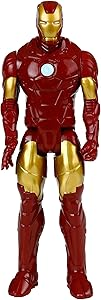

In [16]:
print(sample)
display(sample["messages"][1]['content'][1]['image'])

In [17]:
output = generate_text_from_sample(model, processor, sample['messages'][:3])
output

'Marvel Avengers Assemble Titan Hero Series Iron Man Action Figure (30.5 cm) – Collect this massive, highly detailed Iron Man figure! Perfect for playsets and display.  A must-have for Marvel fans!'